# Retinal OCT Imaging
<hr style="border:2px solid pink">

## Introduction

#### Background

Retinal optical coherence tomography (OCT) is a noninvasive imaging technique that essentially takes pictures of your retinas by measuring how much light reflects off the retina and optic nerve. It can be used to diagnose and manage diseases like diabetes-related retinopathy and glaucoma, amongst others. Millions of OCT scans are performed each year, and the analysis and interpretation of the images can take up a tremendous amount of time.

#### Business Problem

In order to save time and resources in analyzing and interpreting OCT scans, the problem at hand is to create a model that can predict whether a patient's retinal scan is normal or shows signs of CNV, DME, or DRUSEN diseases. 

The stakeholders are medical professionals, specifically ophthalmologists.

#### Data Understanding

The data for this project comes from Kaggle: https://www.kaggle.com/datasets/paultimothymooney/kermany2018/data. It
contains 84,495 images, and 4 categories to predict (NORMAL, CNV, DME, or DRUSEN). 

The data is split into separate train, test, and validation folders. Within each of these, there are labeled sub-folders for each category, with each individual image labeled as such: (disease)-(randomized patient ID)-(image number by
this patient).

The images were selected from adult patients from the Shiley Eye Institute of the University of California San Diego, the California Retinal Research Foundation, Medical Center Ophthalmology Associates, the Shanghai First People’s Hospital, and Beijing Tongren Eye Center between July 1, 2013 and March 1, 2017. 

#### Definitions

According to the National Library of Medicine, the following terms are defined as follows: 

1. CNV: (Choroidal Neovascularization): a condition where abnormal blood vessels grow beneath the retina in the choroid area. These abnormal blood vessels can leak fluid or blood into the retina, which can cause vision loss. Commonly associated with age-related macular degeneration (AMD), which is a leading cause of vision loss in older adults.

2. DME (Diabetic Macular Edema): a complication of diabetic retinopathy, which is an eye condition that can develop in people with diabetes. DME occurs when fluid builds in the macula, the central part of the retina responsible for our central vision, leading to to vision impairment and distortion.

3. Drusen: small yellow or white deposits that accumulate in the retina. They can be found in the macula or the peripheral retina. Drusen are a hallmark sign of age-related macular degeneration (AMD). 

Treatment options for CNV, DME, and AMD may include medications, laser therapy, or in some cases, surgical interventions, depending on the specific condition and its stage.
<hr style="border:2px solid pink">

# General Exploration

To get started, let's import the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.image import imread
%matplotlib inline

from sklearn.dummy import DummyClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate

from sklearn.metrics import confusion_matrix, classification_report,\
recall_score,accuracy_score, precision_score, f1_score, roc_auc_score, ConfusionMatrixDisplay

from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

Let's load in the data next. We need to create directories to where the data is saved, so let's start with that. 

In [2]:
# create directory paths for each folder (train, test, and val)
train_path = 'Data/OCT2017/train'
test_path = 'Data/OCT2017/test'
val_path = 'Data/OCT2017/val'

We'll load in the data normally, no scaling or augmentations done, setting smaller batch sizes, and setting seed=42 to help with reproducibility. 

In [3]:
original_train = ImageDataGenerator().flow_from_directory(train_path, batch_size=200, seed=42)
original_test = ImageDataGenerator().flow_from_directory(test_path, batch_size=100, seed=42)
original_val = ImageDataGenerator().flow_from_directory(val_path, batch_size=5, seed=42)

original_train_images, original_train_labels = next(original_train)
original_test_images, original_test_labels = next(original_test)
original_val_images, original_val_labels = next(original_val)

Found 83484 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


Notice that there are 4 classes: This represents normal, CNV, DME, or Drusen. Before visualizing the distribution, let's find out the original size of the images. We can loop through every image in the images datasets, take the size of it, add it to a list, and take the unique values of the list to confirm each image is the same size. But first, let's look at the shape as this should tell us the size as well. 

In [4]:
print(f"Train Images Shape: {original_train_images.shape}")
print(f"Train Labels Shape: {original_train_labels.shape}")
print(f"Test Images Shape: {original_test_images.shape}")
print(f"Test Labels Shape: {original_test_labels.shape}")
print(f"Val Images Shape: {original_val_images.shape}")
print(f"Val Labels Shape: {original_val_labels.shape}")

Train Images Shape: (200, 256, 256, 3)
Train Labels Shape: (200, 4)
Test Images Shape: (100, 256, 256, 3)
Test Labels Shape: (100, 4)
Val Images Shape: (5, 256, 256, 3)
Val Labels Shape: (5, 4)


It looks like each image is 256x256, but let's confirm this with the loop.

In [5]:
# loop through each images in the array and add the size to an empty list
train_sizes = []
test_sizes = []
val_sizes = []

for img in original_train_images:
    size = np.array(array_to_img(img).size)
    train_sizes.append(size)
    
for img in original_test_images:
    size = np.array(array_to_img(img).size)
    test_sizes.append(size)
    
for img in original_val_images:
    size = np.array(array_to_img(img).size)
    val_sizes.append(size)

In [6]:
# how many unique sizes are in each list? theoretically should be the same for each pic
# change the list of np arrays into a list of tuples, then take the "set" to get unique values

unique_train_sizes = list(set([tuple(size) for size in train_sizes]))
unique_test_sizes = list(set([tuple(size) for size in test_sizes]))
unique_val_sizes = list(set([tuple(size) for size in val_sizes]))

print(f"Original Train Image Size: {unique_train_sizes}")
print(f"Original Test Image Size: {unique_test_sizes}")
print(f"Original Val Image Size: {unique_val_sizes}")

Original Train Image Size: [(256, 256)]
Original Test Image Size: [(256, 256)]
Original Val Image Size: [(256, 256)]


Great! So the original images were indeed all 256x256. Since I noticed when loading in the data that there are 4 classes, let's now take a look at the distribution of the images in our dataset. 

In [7]:
# first, create paths to each individual folder
normal_train_path = 'Data/OCT2017/train/NORMAL'
cnv_train_path = 'Data/OCT2017/train/CNV'
dme_train_path = 'Data/OCT2017/train/DME'
drusen_train_path = 'Data/OCT2017/train/DRUSEN'

# then, take the "length" of each folder to get the total number of images per category
normal_count = len(os.listdir(normal_train_path))
cnv_count = len(os.listdir(cnv_train_path))
dme_count = len(os.listdir(dme_train_path))
drusen_count = len(os.listdir(drusen_train_path))

# print the results
print(f'Normal Count: {normal_count}')
print(f'CNV Count: {cnv_count}')
print(f'DME Count: {dme_count}')
print(f'Drusen Count: {drusen_count}')

Normal Count: 26315
CNV Count: 37205
DME Count: 11348
Drusen Count: 8616


So, there are 26,315 normal images, 37,205 CNV images, 11,348 DME images, and 8,616 Drusen images. Let's visualize the distribution. 

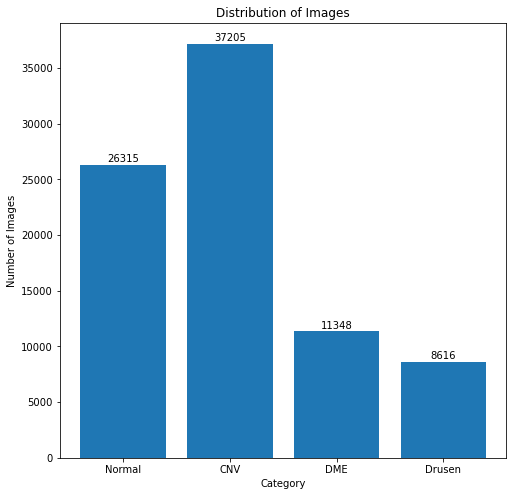

In [8]:
# create the categories for X (categories) and Y (counts)
categories = ['Normal', 'CNV', 'DME', 'Drusen']
counts = [normal_count, cnv_count, dme_count, drusen_count]

# plot it
fig, ax = plt.subplots(figsize=(8,8))
plt.bar(categories, counts)
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Distribution of Images')

# add counts to the top of the bars
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')

plt.show();

This makes the distributions a little more clear! There's the most CNV images and the least Drusen images. 

Let's look at a few images and labels, so we can get an idea of what we're dealing with. 

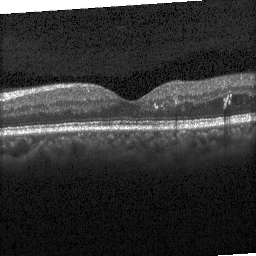

In [9]:
array_to_img(original_train_images[16])

In [10]:
original_train_labels[16]

array([0., 1., 0., 0.], dtype=float32)

In [11]:
original_train.class_indices

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

Ok, so here, I see that each category corresponds to a class. CNV is class 0, DME is class 1, DRUSEN is class 2, and NORMAL is class 3. 

You would interpret the array [0., 1., 0., 0.] as follows: the first class (index 0, corresponds to CNV) has a probability of 0. The second class (index 1, corresponds to DME) has a probability of 1. The third class (index 2, corresponds to Drusen) and the fourth class (index 3, corresponds to normal) have probabilities of 0. This means that the image falls under class 1, and is DME. 

Let's plot a few images from each class, with their corresponding labels titling the plot.

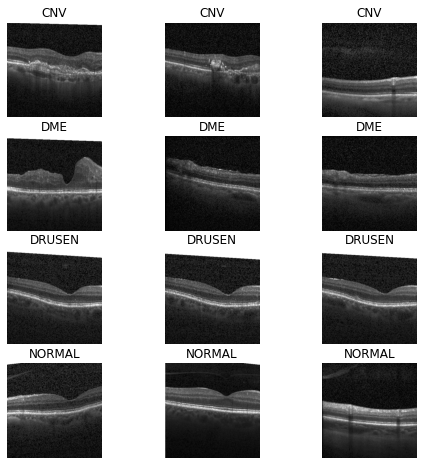

In [12]:
# we have paths to each subfolder, so create a list paths that has them all
# create a list categories with each of the subfolders for labeling purposes
paths = [cnv_train_path, dme_train_path, drusen_train_path, normal_train_path]
categories = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
fig, axes = plt.subplots(nrows=len(categories), ncols=3, figsize=(8, 8))

# iterate through paths to get the image path
for index, path in enumerate(paths):
    image_files = [file for file in os.listdir(path) if file.endswith('.jpeg')]
    
    # Limit the number of images to fit the layout
    total_images_per_cat = min(len(image_files), 3)
    
    for i in range(total_images_per_cat): 
        image_file = image_files[i]
        image_path = os.path.join(path, image_file)
        image = imread(image_path)
        image = image[:400, :400]
            
        # Display the image in a subplot
        ax = axes[index, i]
        ax.imshow(image, cmap='gray')
        ax.set_title(categories[index])  # Display the label
        ax.axis('off')

plt.show()

Great! So we have a little better understanding of what each image might look like. Let's start preprocessing so we can start modeling. 

# Preprocessing

To preprocess the data for a convolutional neural network, I'd like to start the following: 
1. Scale the data: CNNs are sensitive to the scale of input features. By scaling the data, you ensure numerical stability during training. For images, pixel values are usually in the range [0,255], so you can rescale them to the range [0,1] by dividing each pixel by 255.
2. Resize the images: Smaller images can be less computationally intensive, leading to faster training times. This will also help ensure all inputs have the same shape. I will start with decreasing the size to 64x64.
3. Set the seed: To help with reproducibility, I will set the seed equal to 42. 
4. Set the color mode: Since these images are originally in black and white, I will set the color_mode to grayscale to capture this. 

I am loading in smaller batches to help with memory, since larger batches can take up a lot of memory. As this is an iterative process, I may try data augmentation for future models, so I will revisit this step if needed. 

In [13]:
# to remind myself where each path leads
train_path = 'Data/OCT2017/train'
test_path = 'Data/OCT2017/test'
val_path = 'Data/OCT2017/val'

In [14]:
# load in and preprocess the data in smaller batches
# Scale the images, reshape to be 64x64, set the seed, and set the color to grayscale
train_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(train_path, 
                                                                          target_size=(64, 64), 
                                                                          batch_size=200, 
                                                                          seed=42, 
                                                                          color_mode='grayscale')

test_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(test_path, 
                                                                         target_size=(64, 64), 
                                                                         batch_size=100, 
                                                                         seed=42, 
                                                                         color_mode='grayscale')

val_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(val_path, 
                                                                        target_size=(64, 64), 
                                                                        batch_size=5, 
                                                                        seed=42, 
                                                                        color_mode='grayscale')

# next fetches the next batch of data and labels from the generator
# returns a batch of images and their labels
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Found 83484 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


Great! Let's check out the following to make sure everything was properly loaded. 
1. Check out the shapes - everything should be rescaled to 64x64. 
2. Check out the images - everything should be in black and white and smaller in size. 

In [15]:
print(f"Train Images Shape: {train_images.shape}")
print(f"Train Labels Shape: {train_labels.shape}")
print(f"Test Images Shape: {test_images.shape}")
print(f"Test Labels Shape: {test_labels.shape}")
print(f"Val Images Shape: {val_images.shape}")
print(f"Val Labels Shape: {val_labels.shape}")

Train Images Shape: (200, 64, 64, 1)
Train Labels Shape: (200, 4)
Test Images Shape: (100, 64, 64, 1)
Test Labels Shape: (100, 4)
Val Images Shape: (5, 64, 64, 1)
Val Labels Shape: (5, 4)


The shapes all look good! We can see that they are indeed 64x64 for the images, with the color channel as 1, indicating it is grayscale. Next, let's check out a few images. 

In [16]:
train_generator.class_indices

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

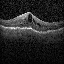

In [17]:
array_to_img(train_images[0])

In [18]:
# second value has probability of 1, so this DME
print(train_labels[0])

[0. 1. 0. 0.]


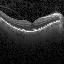

In [19]:
array_to_img(train_images[3])

In [20]:
# last value has probability of 1, so this is normal
print(train_labels[3])

[0. 0. 0. 1.]


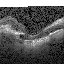

In [21]:
array_to_img(train_images[6])

In [22]:
# first value has probability of 1, so this is CNV
print(train_labels[6])

[1. 0. 0. 0.]


The images look good, they are in black and white, and scaled down to 64x64. 

Now, even though there are separate train, test, and validation folders, the test set only contains 243 images per category (please see below). I think we can use the training set, which contains around 84,000 images, and split it up using a train test split, so we get a more robust testing set. I'll use the preset test set as an additional holdout validation set. 

In [23]:
# first, create paths to each individual folder
normal_test_path = 'Data/OCT2017/test/NORMAL'
cnv_test_path = 'Data/OCT2017/test/CNV'
dme_test_path = 'Data/OCT2017/test/DME'
drusen_test_path = 'Data/OCT2017/test/DRUSEN'

# then, take the "length" of each folder to get the total number of images per category
test_normal_count = len(os.listdir(normal_test_path))
test_cnv_count = len(os.listdir(cnv_test_path))
test_dme_count = len(os.listdir(dme_test_path))
test_drusen_count = len(os.listdir(drusen_test_path))

# print the results
print(f'Normal Count: {test_normal_count}')
print(f'CNV Count: {test_cnv_count}')
print(f'DME Count: {test_dme_count}')
print(f'Drusen Count: {test_drusen_count}')

Normal Count: 243
CNV Count: 243
DME Count: 243
Drusen Count: 243


# Train-Test Split

The train-test split is a crucial step in the modeling process. This split involves dividing the data into two distinct sets: the training dataset and the testing dataset. The training set is used to train the machine learning model, while the testing set serves as unseen, real-world data to assess the model’s performance and accuracy. 

I will use the preset train folder to conduct this split, set random state 42 for reproducibility, and set the size of test set to be 25% of the data. So, out of the approximate 84,000 train images, this will designate around 63,000 images to train the model, and around 21,000 images to test the model with. Let's do it!

In [24]:
# set X = train_images and set y = train_labels

X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.25, random_state=42)

Let's do a quick inspection of the train and test sets to make sure it looks okay before proceeding. First, look at X_train and y_train. 

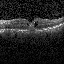

In [25]:
array_to_img(X_train[0])

In [26]:
y_train[0]

array([1., 0., 0., 0.], dtype=float32)

Looks good! Now to check X_test and y_test. 

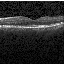

In [27]:
array_to_img(X_test[0])

In [28]:
y_test[0]

array([0., 0., 0., 1.], dtype=float32)

Looks good! Moving forward, I will use X_train and y_train to train my models, and X_test and y_test to test the models performance on unseen data. I will use both the preset test and validation folders (containing roughly 250 images combined) for additional validation. To help avoid confusion, I will rename the test images and labels as extra validation sets. 

In [29]:
# set test_images = extra_val_images and test_labels = extra_val_labels
extra_val_images = test_images
extra_val_labels = test_labels

Let's check out a few images to make sure it looks accurate. 

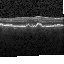

In [30]:
# confirm it worked
array_to_img(extra_val_images[0])

In [31]:
extra_val_labels[0]

array([0., 0., 1., 0.], dtype=float32)

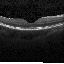

In [32]:
array_to_img(extra_val_images[5])

In [33]:
extra_val_labels[5]

array([0., 0., 0., 1.], dtype=float32)

# Create Functions

Next, let's build some functions next to help speed up viewing the results of each model. 
1. A function that evaluates the model's train and test performance. 
2. A function to plot the loss and accuracy. 
3. A function to plot the confusion matrices. 

Let's start with the evaluate function. We'll print out the loss, accuracy, precision, and recall for both the train and test sets. 

In [34]:
# 1. a function that evaluates the train and test performance of the model
def evaluate_model(model):
    train_results = model.evaluate(X_train, y_train)
    test_results = model.evaluate(X_test, y_test)
    
    print(f'Training Loss: {train_results[0]:.3} \nTraining Accuracy: {train_results[1]:.3} \nTraining Precision: {train_results[2]:.3} \nTraining Recall: {train_results[3]:.3}')  
    print('---------------------------')
    print(f'Testing Loss: {test_results[0]:.3} \nTesting Accuracy: {test_results[1]:.3} \nTesting Precision: {test_results[2]:.3} \nTesting Recall: {test_results[3]:.3}')    

Next, let's create a function to plot the loss and accuracy for us. 

In [35]:
# 2. a function to plot the loss and accuracy
def plot_metrics(results):
    train_loss = results.history['loss']
    train_accuracy = results.history['accuracy']

    val_loss = results.history['val_loss']
    val_accuracy = results.history['val_accuracy']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
    sns.lineplot(x=results.epoch, y=train_accuracy, ax=ax2, label='train_accuracy')

    sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
    sns.lineplot(x=results.epoch, y=val_accuracy, ax=ax2, label='val_accuracy')
    
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')

    plt.tight_layout()
    plt.show();

Finally, let's create a function to plot the confusion matrix for us.

confusion matrix only plotting for individual batches, can't get it for the test set AFTER the train test split

In [36]:
# 3. a function to plot the confusion matrix
def plot_confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=['CNV', 'DME', 'DRUSEN', 'NORMAL'], columns=['CNV', 'DME', 'DRUSEN', 'NORMAL'])

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

# Baseline model

For my baseline model, I will use a simple convolutional neural network with no hidden convolutional layers. I will begin with a dense input layer, expecting grayscale images of size 64x64x1. The input layer will have 64 units and use the ReLU activation function to introduce non-linearity and capture complex features. Next, I will add a flatten layer to transform the output from the previous layer into a 1D vector, preparing it for the final output layer. The output layer will consist of a dense layer with 4 units to represent the 4 classes, and it will use the softmax activation function, which is a common choice for multi-class classification tasks.

In [37]:
baseline_model = Sequential()
baseline_model.add(Dense(64, activation='relu', input_shape=(64, 64, 1)))
baseline_model.add(Flatten())
baseline_model.add(Dense(4, activation='softmax'))

Let's view the architecture of the model. 

In [38]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64, 64, 64)        128       
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1048580   
Total params: 1,048,708
Trainable params: 1,048,708
Non-trainable params: 0
_________________________________________________________________


So we can see that there are a LOT of parameters for such a simple model! Must be due to the size of the dataset. Let's compile the model using the adam optimizer (Adam is a good starting choice because Adam is an adaptive learning rate optimization algorithm. It should help with a more efficient convergence), categorical crossentropy as the loss (this is an appropriate choice for a multi-class classsification task), and accuracy as the metric. 

In [39]:
precision = Precision()
recall = Recall()

In [40]:
baseline_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', precision, recall])

Finally, let's fit the model on the train set. I will use the following parameters: 
- Smaller batches of 100, meaning my model will process 100 training samples at a time before adjusting the weights. 
- 25 epochs: epochs specifies how many times the model will iterate over the entire dataset. 
- Validation data: Remember the train test split? I will use the original test_images dataset with 243 images as my validation data in this case, as we have a separate test set from the train test split. 

In [41]:
baseline_results = baseline_model.fit(X_train, 
                                      y_train, 
                                      batch_size=100, 
                                      epochs=25,
                                      validation_data=(extra_val_images, extra_val_labels))

Epoch 1/25
2/2 [==============================] - 1s 285ms/step - loss: 1.6750 - accuracy: 0.2867 - precision: 0.4600 - recall: 0.1533 - val_loss: 4.5721 - val_accuracy: 0.2600 - val_precision: 0.2626 - val_recall: 0.2600
Epoch 2/25
2/2 [==============================] - 0s 49ms/step - loss: 2.0420 - accuracy: 0.4800 - precision: 0.4765 - recall: 0.4733 - val_loss: 3.0971 - val_accuracy: 0.2500 - val_precision: 0.2340 - val_recall: 0.2200
Epoch 3/25
2/2 [==============================] - 0s 50ms/step - loss: 1.3233 - accuracy: 0.5800 - precision: 0.6061 - recall: 0.5333 - val_loss: 1.5636 - val_accuracy: 0.1900 - val_precision: 0.2222 - val_recall: 0.0200
Epoch 4/25
2/2 [==============================] - 0s 54ms/step - loss: 1.3591 - accuracy: 0.3600 - precision: 0.7333 - recall: 0.0733 - val_loss: 1.5128 - val_accuracy: 0.2500 - val_precision: 0.1905 - val_recall: 0.0400
Epoch 5/25
2/2 [==============================] - 0s 54ms/step - loss: 0.9842 - accuracy: 0.6467 - precision: 0.785

Great! Let's evaluate the scores. 

In [42]:
evaluate_model(baseline_model)

2/2 [==============================] - 0s 5ms/step - loss: 1.9544 - accuracy: 0.3400 - precision: 0.3721 - recall: 0.3200
Training Loss: 0.332 
Training Accuracy: 0.94 
Training Precision: 0.985 
Training Recall: 0.887
---------------------------
Testing Loss: 1.95 
Testing Accuracy: 0.34 
Testing Precision: 0.372 
Testing Recall: 0.32


This is very overfit! We have a train accuracy of 91% and a test accuracy of 34%. Training recall and precision are pretty high, standing at 97% for precision and 81% for recall, but again, the test scores are abysmal. Test precision stands at 39% and test recall stands at 32%. Let's visualize the loss and accuracy. 

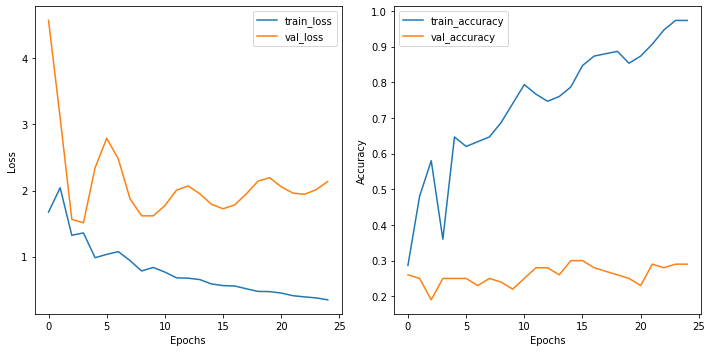

In [43]:
plot_metrics(baseline_results)

UPDATE LATER: 
Here, we can see that the train loss is decreasing, val loss is jumping all over the place, train accuracy is steadily increasing, but val accuracy is low. 

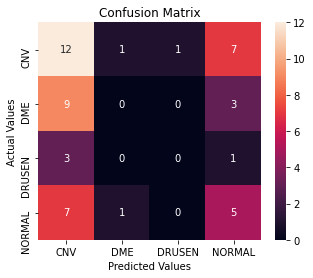

In [44]:
plot_confusion_matrix(baseline_model, X_test, y_test)

INTERPRETATION: 

# First Simple Model

My baseline model was very overfit, let's try making it more complex and adding some hidden layers. Will add convolutional and max pooling. 

In [45]:
first_model = Sequential()

first_model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(64, 64, 1)))
first_model.add(MaxPooling2D(pool_size=(2,2)))

first_model.add(Conv2D(64, (3, 3), activation='relu'))
first_model.add(MaxPooling2D(pool_size=(2,2)))

first_model.add(Flatten())
first_model.add(Dense(4, activation='softmax'))

In [46]:
first_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 50180     
Total params: 68,996
Trainable params: 68,996
Non-trainable params: 0
__________________________________________________

A lot less params. 

In [47]:
first_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', precision, recall])

In [48]:
first_model_results = first_model.fit(X_train, 
                                      y_train, 
                                      batch_size=100, 
                                      epochs=25,
                                      validation_data=(extra_val_images, extra_val_labels))

Epoch 1/25
2/2 [==============================] - 1s 300ms/step - loss: 1.3520 - accuracy: 0.2333 - precision: 0.3721 - recall: 0.0800 - val_loss: 1.5784 - val_accuracy: 0.2200 - val_precision: 0.1111 - val_recall: 0.0100
Epoch 2/25
2/2 [==============================] - 0s 57ms/step - loss: 1.1835 - accuracy: 0.4800 - precision: 0.5667 - recall: 0.2267 - val_loss: 1.9253 - val_accuracy: 0.2200 - val_precision: 0.2211 - val_recall: 0.2100
Epoch 3/25
2/2 [==============================] - 0s 68ms/step - loss: 1.1709 - accuracy: 0.4933 - precision: 0.5462 - recall: 0.4333 - val_loss: 1.7738 - val_accuracy: 0.2400 - val_precision: 0.1667 - val_recall: 0.0600
Epoch 4/25
2/2 [==============================] - 0s 82ms/step - loss: 1.1242 - accuracy: 0.5800 - precision: 0.6552 - recall: 0.2533 - val_loss: 1.5952 - val_accuracy: 0.2700 - val_precision: 0.1429 - val_recall: 0.0200
Epoch 5/25
2/2 [==============================] - 0s 108ms/step - loss: 1.1287 - accuracy: 0.5533 - precision: 0.79

In [49]:
evaluate_model(first_model)

2/2 [==============================] - 0s 17ms/step - loss: 1.5725 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.3600
Training Loss: 0.595 
Training Accuracy: 0.773 
Training Precision: 0.864 
Training Recall: 0.68
---------------------------
Testing Loss: 1.57 
Testing Accuracy: 0.5 
Testing Precision: 0.5 
Testing Recall: 0.36


A little bit better - train accuracy at 77%, precision at 90%, recall at 63%. Testing accuracy is higher at 42%, precision at 45%, and recall at 28%. 

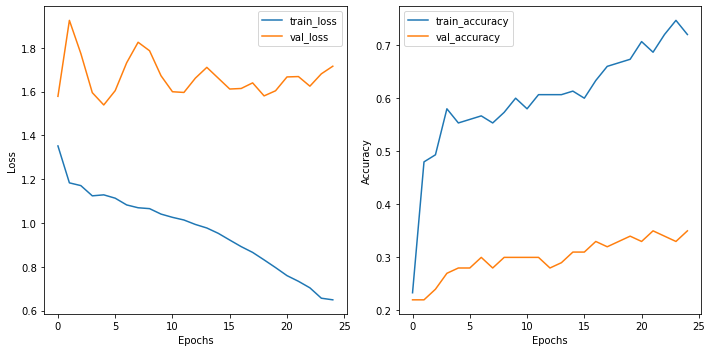

In [50]:
plot_metrics(first_model_results)

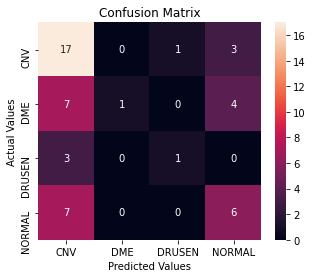

In [51]:
plot_confusion_matrix(first_model, X_test, y_test)

# Second Model

Let's add more complexity - more conv and 2d layers, add some dense layers, and add dense layer after flatten. 

In [52]:
second_model = Sequential()

second_model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(64, 64, 1)))
second_model.add(MaxPooling2D(pool_size=(2,2)))

second_model.add(Conv2D(64, (3, 3), activation='relu'))
second_model.add(MaxPooling2D(pool_size=(2,2)))

second_model.add(Conv2D(32, (3, 3), activation='relu'))
second_model.add(MaxPooling2D(pool_size=(2,2)))

second_model.add(Flatten())
second_model.add(Dense(32, activation='relu'))
second_model.add(Dense(16, activation='relu'))
second_model.add(Dense(4, activation='softmax'))

In [53]:
second_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 32)        18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)             

More params than first model, less than baseline. Compile and fit the model. 

In [54]:
second_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', precision, recall])

In [55]:
second_model_results = second_model.fit(X_train, 
                                      y_train, 
                                      batch_size=100, 
                                      epochs=25,
                                      validation_data=(extra_val_images, extra_val_labels))

Epoch 1/25
2/2 [==============================] - 1s 509ms/step - loss: 1.3712 - accuracy: 0.4267 - precision: 0.5000 - recall: 0.0900 - val_loss: 1.3994 - val_accuracy: 0.2200 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
2/2 [==============================] - 0s 155ms/step - loss: 1.2935 - accuracy: 0.4800 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4719 - val_accuracy: 0.2200 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
2/2 [==============================] - 0s 160ms/step - loss: 1.2177 - accuracy: 0.4800 - precision: 0.4667 - recall: 0.1400 - val_loss: 1.6379 - val_accuracy: 0.2200 - val_precision: 0.2283 - val_recall: 0.2100
Epoch 4/25
2/2 [==============================] - 0s 178ms/step - loss: 1.1795 - accuracy: 0.4800 - precision: 0.5308 - recall: 0.4600 - val_loss: 1.6330 - val_accuracy: 0.2200 - val_precision: 0.2708 - val_recall: 0.1300
Epoch 5/25
2/2 [==============================] - 0s 168ms/step - loss: 1.1558 - accurac

In [56]:
evaluate_model(second_model)

2/2 [==============================] - 0s 20ms/step - loss: 1.3962 - accuracy: 0.4000 - precision: 0.5000 - recall: 0.2800
Training Loss: 0.922 
Training Accuracy: 0.633 
Training Precision: 0.79 
Training Recall: 0.553
---------------------------
Testing Loss: 1.4 
Testing Accuracy: 0.4 
Testing Precision: 0.5 
Testing Recall: 0.28


Worse all around

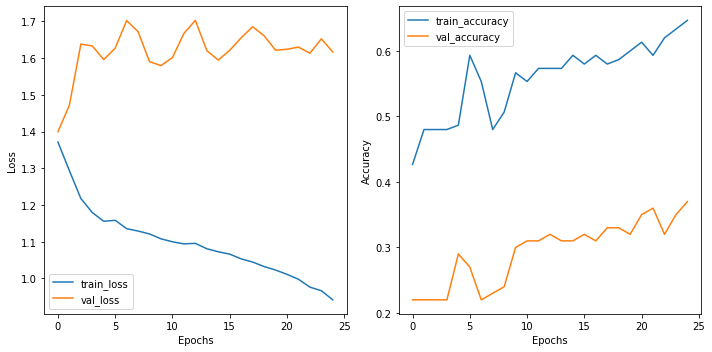

In [57]:
plot_metrics(second_model_results)

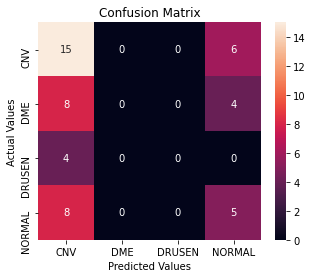

In [58]:
plot_confusion_matrix(second_model, X_test, y_test)

Let's try increasing the input units. Same model as second model otherwise. 

# Third Model

In [59]:
third_model = Sequential()

third_model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(64, 64, 1)))
third_model.add(MaxPooling2D(pool_size=(2,2)))

third_model.add(Conv2D(128, (3, 3), activation='relu')) # increased from 64 to 128
third_model.add(MaxPooling2D(pool_size=(2,2)))

third_model.add(Conv2D(64, (3, 3), activation='relu')) # increased from 32 to 64
third_model.add(MaxPooling2D(pool_size=(2,2)))

third_model.add(Flatten())
third_model.add(Dense(64, activation='relu')) # increased from 32 to 64
third_model.add(Dense(32, activation='relu')) # increased from 16 to 32
third_model.add(Dense(4, activation='softmax'))

In [60]:
third_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2304)             

More params!

In [61]:
third_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', precision, recall])

In [62]:
third_model_results = third_model.fit(X_train, 
                                      y_train, 
                                      batch_size=100, 
                                      epochs=25,
                                      validation_data=(extra_val_images, extra_val_labels))

Epoch 1/25
2/2 [==============================] - 1s 469ms/step - loss: 1.3800 - accuracy: 0.1667 - precision: 0.5000 - recall: 0.0700 - val_loss: 1.4238 - val_accuracy: 0.2300 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
2/2 [==============================] - 0s 126ms/step - loss: 1.2668 - accuracy: 0.5133 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.7417 - val_accuracy: 0.2200 - val_precision: 0.2346 - val_recall: 0.1900
Epoch 3/25
2/2 [==============================] - 0s 181ms/step - loss: 1.1693 - accuracy: 0.4800 - precision: 0.5120 - recall: 0.4267 - val_loss: 1.8607 - val_accuracy: 0.2200 - val_precision: 0.2237 - val_recall: 0.1700
Epoch 4/25
2/2 [==============================] - 0s 223ms/step - loss: 1.1603 - accuracy: 0.5000 - precision: 0.5579 - recall: 0.3533 - val_loss: 1.6615 - val_accuracy: 0.3200 - val_precision: 0.1538 - val_recall: 0.0200
Epoch 5/25
2/2 [==============================] - 1s 273ms/step - loss: 1.1336 - accuracy: 0.566

In [63]:
evaluate_model(third_model)

2/2 [==============================] - 0s 10ms/step - loss: 1.3569 - accuracy: 0.4800 - precision: 0.5000 - recall: 0.3200
Training Loss: 0.83 
Training Accuracy: 0.687 
Training Precision: 0.771 
Training Recall: 0.607
---------------------------
Testing Loss: 1.36 
Testing Accuracy: 0.48 
Testing Precision: 0.5 
Testing Recall: 0.32


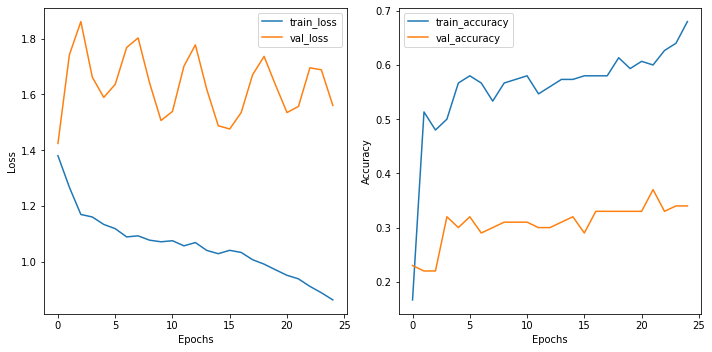

In [64]:
plot_metrics(third_model_results)

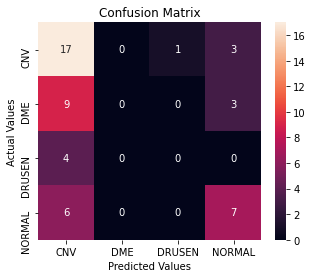

In [65]:
plot_confusion_matrix(third_model, X_test, y_test)

Performed about the same as second model. 

Let's try adding regularization. 

# Fourth Model

Add regulurization, start with just L2. 

In [66]:
fourth_model = Sequential()

fourth_model.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(64, 64, 1), 
                        kernel_regularizer=l2(0.01)))

fourth_model.add(MaxPooling2D(pool_size=(2,2)))

fourth_model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
fourth_model.add(MaxPooling2D(pool_size=(2,2)))

fourth_model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
fourth_model.add(MaxPooling2D(pool_size=(2,2)))

fourth_model.add(Flatten())
fourth_model.add(Dense(64, activation='relu'))
fourth_model.add(Dense(32, activation='relu'))
fourth_model.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.01)))

In [67]:
fourth_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2304)             

In [68]:
fourth_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', precision, recall])

In [69]:
fourth_model_results = fourth_model.fit(X_train, 
                                      y_train, 
                                      batch_size=100, 
                                      epochs=25,
                                      validation_data=(extra_val_images, extra_val_labels))

Epoch 1/25
2/2 [==============================] - 1s 482ms/step - loss: 2.8746 - accuracy: 0.0933 - precision: 0.5000 - recall: 0.0800 - val_loss: 2.7509 - val_accuracy: 0.3400 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
2/2 [==============================] - 0s 144ms/step - loss: 2.7327 - accuracy: 0.2400 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.6449 - val_accuracy: 0.2200 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
2/2 [==============================] - 0s 189ms/step - loss: 2.6180 - accuracy: 0.4800 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.5423 - val_accuracy: 0.2200 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
2/2 [==============================] - 0s 236ms/step - loss: 2.4987 - accuracy: 0.4800 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.4467 - val_accuracy: 0.2200 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
2/2 [==============================] - 1s 266

In [70]:
evaluate_model(fourth_model)

2/2 [==============================] - 0s 14ms/step - loss: 1.6872 - accuracy: 0.3400 - precision: 0.3143 - recall: 0.2200
Training Loss: 1.24 
Training Accuracy: 0.587 
Training Precision: 0.649 
Training Recall: 0.493
---------------------------
Testing Loss: 1.69 
Testing Accuracy: 0.34 
Testing Precision: 0.314 
Testing Recall: 0.22


About the same. 

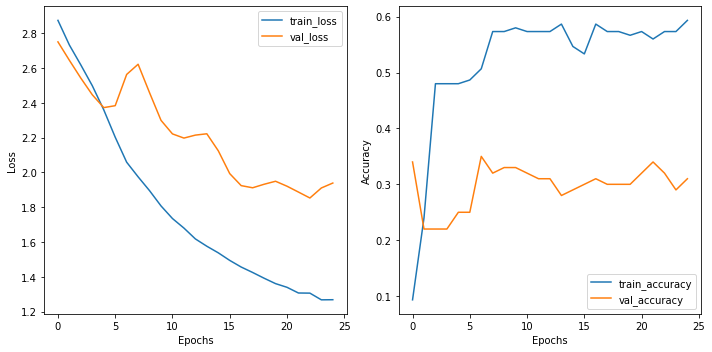

In [71]:
plot_metrics(fourth_model_results)

Let's try adding dropout regularization. 

# Fifth Model

In [73]:
fifth_model = Sequential()

fifth_model.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(64, 64, 1), 
                        kernel_regularizer=l2(0.01)))

fifth_model.add(MaxPooling2D(pool_size=(2,2)))
fifth_model.add(Dropout(0.8))

fifth_model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
fifth_model.add(MaxPooling2D(pool_size=(2,2)))
fifth_model.add(Dropout(0.5))

fifth_model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
fifth_model.add(MaxPooling2D(pool_size=(2,2)))
fifth_model.add(Dropout(0.2))

fifth_model.add(Flatten())
fifth_model.add(Dense(64, activation='relu'))
fifth_model.add(Dense(32, activation='relu'))
fifth_model.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.01)))

In [74]:
fifth_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 12, 12, 64)       

In [75]:
fifth_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', precision, recall])

In [76]:
fifth_model_results = fifth_model.fit(X_train, 
                                      y_train, 
                                      batch_size=100, 
                                      epochs=25,
                                      validation_data=(extra_val_images, extra_val_labels))

Epoch 1/25
2/2 [==============================] - 1s 503ms/step - loss: 2.7826 - accuracy: 0.3200 - precision: 0.3143 - recall: 0.0550 - val_loss: 2.8173 - val_accuracy: 0.2200 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
2/2 [==============================] - 0s 129ms/step - loss: 2.5827 - accuracy: 0.4800 - precision: 0.5385 - recall: 0.3267 - val_loss: 2.7648 - val_accuracy: 0.2200 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
2/2 [==============================] - 0s 168ms/step - loss: 2.5188 - accuracy: 0.4800 - precision: 0.5000 - recall: 0.4400 - val_loss: 2.6779 - val_accuracy: 0.2200 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
2/2 [==============================] - 0s 231ms/step - loss: 2.4330 - accuracy: 0.4800 - precision: 0.6154 - recall: 0.1600 - val_loss: 2.6031 - val_accuracy: 0.2200 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
2/2 [==============================] - 0s 225ms/step - loss: 2.3501 -

In [77]:
evaluate_model(fifth_model)

2/2 [==============================] - 0s 17ms/step - loss: 1.6497 - accuracy: 0.3000 - precision: 0.5000 - recall: 0.0200
Training Loss: 1.48 
Training Accuracy: 0.567 
Training Precision: 1.0 
Training Recall: 0.0533
---------------------------
Testing Loss: 1.65 
Testing Accuracy: 0.3 
Testing Precision: 0.5 
Testing Recall: 0.02


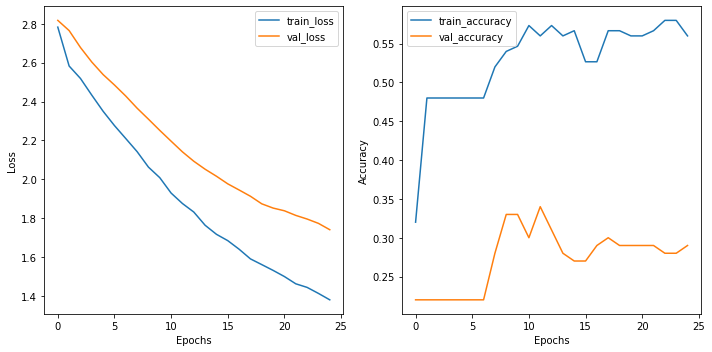

In [78]:
plot_metrics(fifth_model_results)

# Sixth Model

Let's try adding dense hidden layers. 

In [79]:
sixth_model = Sequential()

sixth_model.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(64, 64, 1), 
                        kernel_regularizer=l2(0.01)))

sixth_model.add(Dense(128, activation='relu'))
sixth_model.add(MaxPooling2D(pool_size=(2,2)))
sixth_model.add(Dropout(0.8))

sixth_model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
sixth_model.add(Dense(64, activation='relu'))
sixth_model.add(MaxPooling2D(pool_size=(2,2)))
sixth_model.add(Dropout(0.5))

sixth_model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
sixth_model.add(Dense(32, activation='relu'))
sixth_model.add(MaxPooling2D(pool_size=(2,2)))
sixth_model.add(Dropout(0.2))

sixth_model.add(Flatten())
sixth_model.add(Dense(64, activation='relu'))
sixth_model.add(Dense(32, activation='relu'))
sixth_model.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.01)))

In [80]:
sixth_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
dense_15 (Dense)             (None, 62, 62, 128)       4224      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 29, 29, 128)       147584    
_________________________________________________________________
dense_16 (Dense)             (None, 29, 29, 64)        8256      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 64)       

That added more params, let's check it out. 

In [81]:
sixth_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', precision, recall])

In [82]:
sixth_model_results = sixth_model.fit(X_train, 
                                      y_train, 
                                      batch_size=100, 
                                      epochs=25,
                                      validation_data=(extra_val_images, extra_val_labels))

Epoch 1/25
2/2 [==============================] - 2s 1s/step - loss: 3.4058 - accuracy: 0.2000 - precision: 0.5000 - recall: 0.0050 - val_loss: 3.2475 - val_accuracy: 0.2200 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
2/2 [==============================] - 1s 535ms/step - loss: 3.1845 - accuracy: 0.4867 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 3.0918 - val_accuracy: 0.2200 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
2/2 [==============================] - 1s 517ms/step - loss: 2.9802 - accuracy: 0.4800 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.9529 - val_accuracy: 0.2200 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
2/2 [==============================] - 1s 654ms/step - loss: 2.7572 - accuracy: 0.4800 - precision: 0.5833 - recall: 0.0467 - val_loss: 2.8726 - val_accuracy: 0.2200 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
2/2 [==============================] - 1s 577ms/step - l

In [83]:
evaluate_model(sixth_model)

2/2 [==============================] - 0s 41ms/step - loss: 1.6415 - accuracy: 0.2800 - precision: 0.3333 - recall: 0.0800
Training Loss: 1.36 
Training Accuracy: 0.58 
Training Precision: 0.789 
Training Recall: 0.2
---------------------------
Testing Loss: 1.64 
Testing Accuracy: 0.28 
Testing Precision: 0.333 
Testing Recall: 0.08


The loss looks better but the accuracy! still terrible ugh.

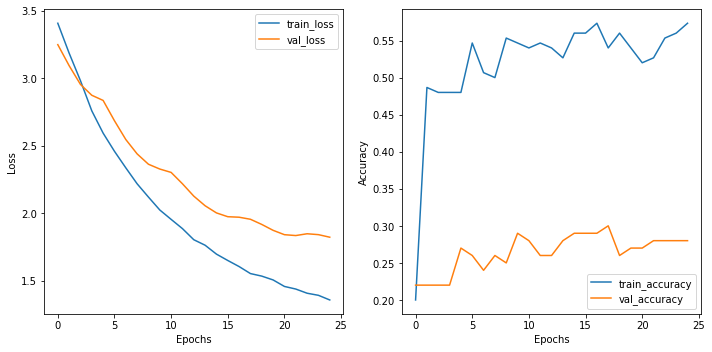

In [84]:
plot_metrics(sixth_model_results)

Not really getting better results yet, still overfit and not performing that well. Let's try adding early stopping to help with the overfitting. 

In [85]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5)

In [86]:
seventh_model = Sequential()

seventh_model.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(64, 64, 1), 
                        kernel_regularizer=l2(0.01)))

seventh_model.add(Dense(128, activation='relu'))
seventh_model.add(MaxPooling2D(pool_size=(2,2)))
seventh_model.add(Dropout(0.8))

seventh_model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
seventh_model.add(Dense(64, activation='relu'))
seventh_model.add(MaxPooling2D(pool_size=(2,2)))
seventh_model.add(Dropout(0.5))

seventh_model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
seventh_model.add(Dense(32, activation='relu'))
seventh_model.add(MaxPooling2D(pool_size=(2,2)))
seventh_model.add(Dropout(0.2))

seventh_model.add(Flatten())
seventh_model.add(Dense(64, activation='relu'))
seventh_model.add(Dense(32, activation='relu'))
seventh_model.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.01)))

In [87]:
seventh_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
dense_21 (Dense)             (None, 62, 62, 128)       4224      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 29, 29, 128)       147584    
_________________________________________________________________
dense_22 (Dense)             (None, 29, 29, 64)        8256      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 64)       

In [88]:
seventh_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', precision, recall])

In [89]:
seventh_model_results = seventh_model.fit(X_train, 
                                      y_train, 
                                      batch_size=100, 
                                      epochs=25,
                                      validation_data=(extra_val_images, extra_val_labels),
                                      callbacks=[early_stop])

Epoch 1/25
2/2 [==============================] - 2s 892ms/step - loss: 3.3681 - accuracy: 0.2067 - precision: 0.3333 - recall: 0.0200 - val_loss: 3.2226 - val_accuracy: 0.2200 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
2/2 [==============================] - 1s 459ms/step - loss: 3.1293 - accuracy: 0.4800 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 3.0767 - val_accuracy: 0.2200 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
2/2 [==============================] - 1s 516ms/step - loss: 2.8911 - accuracy: 0.4800 - precision: 0.5758 - recall: 0.1267 - val_loss: 2.9982 - val_accuracy: 0.2200 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
2/2 [==============================] - 1s 498ms/step - loss: 2.7215 - accuracy: 0.4800 - precision: 0.4828 - recall: 0.4667 - val_loss: 2.8463 - val_accuracy: 0.2200 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
2/2 [==============================] - 1s 455ms/step - loss: 

In [90]:
evaluate_model(seventh_model)

2/2 [==============================] - 0s 47ms/step - loss: 1.5875 - accuracy: 0.3000 - precision: 0.3333 - recall: 0.0800
Training Loss: 1.34 
Training Accuracy: 0.587 
Training Precision: 0.723 
Training Recall: 0.227
---------------------------
Testing Loss: 1.59 
Testing Accuracy: 0.3 
Testing Precision: 0.333 
Testing Recall: 0.08


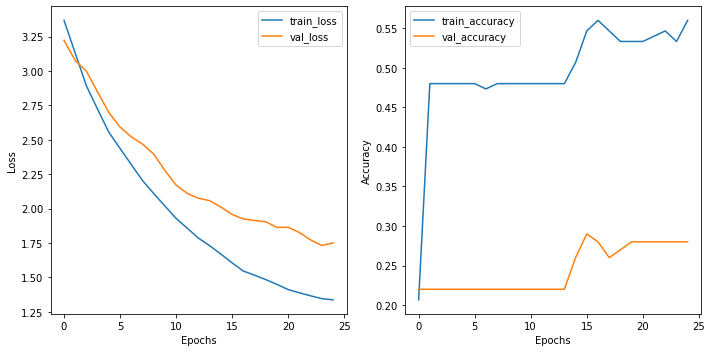

In [91]:
plot_metrics(seventh_model_results)

Maybe my model is too complex, let's try reducing some layers and see if that helps performance. 

In [92]:
eighth_model = Sequential()

eighth_model.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(64, 64, 1), 
                        kernel_regularizer=l2(0.01)))

eighth_model.add(Dense(128, activation='relu'))
eighth_model.add(MaxPooling2D(pool_size=(2,2)))
eighth_model.add(Dropout(0.8))

eighth_model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
eighth_model.add(Dense(64, activation='relu'))
eighth_model.add(MaxPooling2D(pool_size=(2,2)))
eighth_model.add(Dropout(0.5))

eighth_model.add(Flatten())
eighth_model.add(Dense(64, activation='relu'))
eighth_model.add(Dense(32, activation='relu'))
eighth_model.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.01)))

In [93]:
eighth_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
dense_27 (Dense)             (None, 62, 62, 128)       4224      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 29, 29, 128)       147584    
_________________________________________________________________
dense_28 (Dense)             (None, 29, 29, 64)        8256      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 14, 14, 64)       

More params!

In [94]:
eighth_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', precision, recall])

In [95]:
eighth_model_results = eighth_model.fit(X_train, 
                                      y_train, 
                                      batch_size=100, 
                                      epochs=25,
                                      validation_data=(extra_val_images, extra_val_labels),
                                      callbacks=[early_stop])

Epoch 1/25
2/2 [==============================] - 2s 1s/step - loss: 2.6219 - accuracy: 0.3733 - precision: 0.5385 - recall: 0.0700 - val_loss: 2.8534 - val_accuracy: 0.2200 - val_precision: 0.2222 - val_recall: 0.0400
Epoch 2/25
2/2 [==============================] - 1s 616ms/step - loss: 2.5633 - accuracy: 0.4933 - precision: 0.4957 - recall: 0.3867 - val_loss: 2.5811 - val_accuracy: 0.2700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
2/2 [==============================] - 1s 597ms/step - loss: 2.3147 - accuracy: 0.4467 - precision: 0.6000 - recall: 0.1200 - val_loss: 2.4444 - val_accuracy: 0.2800 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
2/2 [==============================] - 1s 505ms/step - loss: 2.1863 - accuracy: 0.5467 - precision: 0.7368 - recall: 0.0933 - val_loss: 2.3512 - val_accuracy: 0.2300 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
2/2 [==============================] - 1s 485ms/step - loss: 2.0933 - accuracy: 

In [96]:
evaluate_model(eighth_model)

2/2 [==============================] - 0s 38ms/step - loss: 1.5394 - accuracy: 0.3600 - precision: 0.3333 - recall: 0.0800
Training Loss: 1.24 
Training Accuracy: 0.607 
Training Precision: 0.838 
Training Recall: 0.207
---------------------------
Testing Loss: 1.54 
Testing Accuracy: 0.36 
Testing Precision: 0.333 
Testing Recall: 0.08


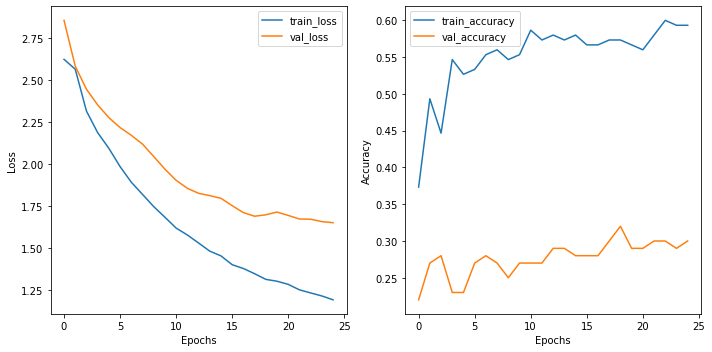

In [97]:
plot_metrics(eighth_model_results)

# Ninth Model

Let's try reducing regulurization strength. 

In [98]:
ninth_model = Sequential()

ninth_model.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(64, 64, 1), 
                        kernel_regularizer=l2(0.0001)))

ninth_model.add(Dense(128, activation='relu'))
ninth_model.add(MaxPooling2D(pool_size=(2,2)))
ninth_model.add(Dropout(0.8))

ninth_model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
ninth_model.add(Dense(64, activation='relu'))
ninth_model.add(MaxPooling2D(pool_size=(2,2)))
ninth_model.add(Dropout(0.5))

ninth_model.add(Flatten())
ninth_model.add(Dense(64, activation='relu'))
ninth_model.add(Dense(32, activation='relu'))
ninth_model.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.0001)))

In [99]:
ninth_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
dense_32 (Dense)             (None, 62, 62, 128)       4224      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 29, 29, 128)       147584    
_________________________________________________________________
dense_33 (Dense)             (None, 29, 29, 64)        8256      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 14, 14, 64)       

In [100]:
ninth_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', precision, recall])

In [101]:
ninth_model_results = ninth_model.fit(X_train, 
                                      y_train, 
                                      batch_size=100, 
                                      epochs=25,
                                      validation_data=(extra_val_images, extra_val_labels),
                                      callbacks=[early_stop])

Epoch 1/25
2/2 [==============================] - 1s 728ms/step - loss: 1.3652 - accuracy: 0.2533 - precision: 0.3333 - recall: 0.0200 - val_loss: 1.4194 - val_accuracy: 0.2200 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
2/2 [==============================] - 1s 462ms/step - loss: 1.2040 - accuracy: 0.4800 - precision: 0.5730 - recall: 0.3400 - val_loss: 1.4521 - val_accuracy: 0.2400 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
2/2 [==============================] - 1s 541ms/step - loss: 1.1912 - accuracy: 0.5400 - precision: 0.7083 - recall: 0.2267 - val_loss: 1.4304 - val_accuracy: 0.2800 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
2/2 [==============================] - 1s 646ms/step - loss: 1.1653 - accuracy: 0.5667 - precision: 0.6765 - recall: 0.1533 - val_loss: 1.4302 - val_accuracy: 0.2600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
2/2 [==============================] - 1s 522ms/step - loss: 1.1410 -

In [102]:
evaluate_model(ninth_model)

2/2 [==============================] - 0s 44ms/step - loss: 1.3482 - accuracy: 0.3600 - precision: 0.0000e+00 - recall: 0.0000e+00
Training Loss: 1.24 
Training Accuracy: 0.56 
Training Precision: 1.0 
Training Recall: 0.00667
---------------------------
Testing Loss: 1.35 
Testing Accuracy: 0.36 
Testing Precision: 0.0 
Testing Recall: 0.0


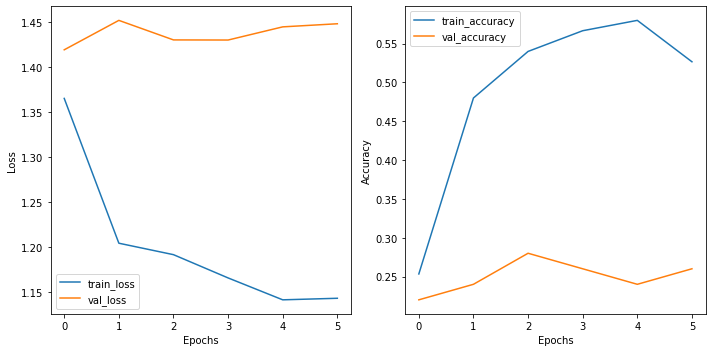

In [103]:
plot_metrics(ninth_model_results)

# Tenth Model

Let's add batch normalization.

In [104]:
tenth_model = Sequential()

tenth_model.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(64, 64, 1), 
                        kernel_regularizer=l2(0.0001)))
tenth_model.add(BatchNormalization())
tenth_model.add(Dense(128, activation='relu'))
tenth_model.add(MaxPooling2D(pool_size=(2,2)))
tenth_model.add(Dropout(0.8))

tenth_model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
tenth_model.add(BatchNormalization())
tenth_model.add(Dense(64, activation='relu'))
tenth_model.add(MaxPooling2D(pool_size=(2,2)))
tenth_model.add(Dropout(0.5))

tenth_model.add(Flatten())
tenth_model.add(Dense(64, activation='relu'))
tenth_model.add(Dense(32, activation='relu'))
tenth_model.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.0001)))

In [105]:
tenth_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 32)        128       
_________________________________________________________________
dense_37 (Dense)             (None, 62, 62, 128)       4224      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 29, 29, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 29, 128)     

In [106]:
tenth_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', precision, recall])

In [107]:
tenth_model_results = tenth_model.fit(X_train, 
                                      y_train, 
                                      batch_size=100, 
                                      epochs=25,
                                      validation_data=(extra_val_images, extra_val_labels),
                                      callbacks=[early_stop])

Epoch 1/25
2/2 [==============================] - 2s 1s/step - loss: 4.1880 - accuracy: 0.2600 - precision: 0.2727 - recall: 0.1800 - val_loss: 1.3994 - val_accuracy: 0.2900 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
2/2 [==============================] - 1s 625ms/step - loss: 1.6180 - accuracy: 0.4267 - precision: 0.4298 - recall: 0.3267 - val_loss: 1.4011 - val_accuracy: 0.3100 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
2/2 [==============================] - 1s 605ms/step - loss: 1.2851 - accuracy: 0.4533 - precision: 0.4872 - recall: 0.3800 - val_loss: 1.4033 - val_accuracy: 0.2700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
2/2 [==============================] - 1s 661ms/step - loss: 1.3680 - accuracy: 0.5600 - precision: 0.6016 - recall: 0.5133 - val_loss: 1.4016 - val_accuracy: 0.2700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
2/2 [==============================] - 1s 612ms/step - loss: 1.3554 - ac

In [108]:
evaluate_model(tenth_model)

2/2 [==============================] - 0s 35ms/step - loss: 1.3971 - accuracy: 0.2400 - precision: 0.0000e+00 - recall: 0.0000e+00
Training Loss: 1.39 
Training Accuracy: 0.253 
Training Precision: 0.0 
Training Recall: 0.0
---------------------------
Testing Loss: 1.4 
Testing Accuracy: 0.24 
Testing Precision: 0.0 
Testing Recall: 0.0


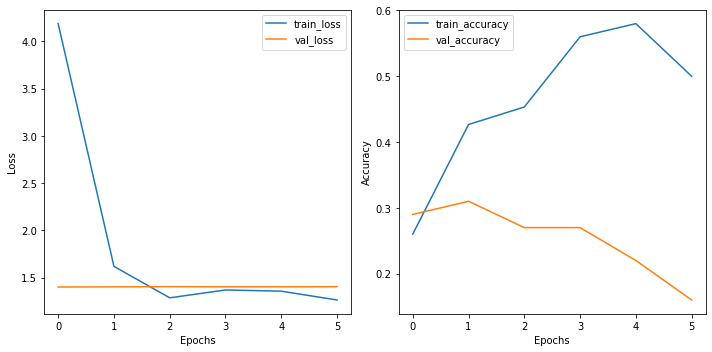

In [109]:
plot_metrics(tenth_model_results)

# Eleventh Model

Scores are worse all around, but not overfit. Let's try reducing regularization, see if that helps. 

In [110]:
# removed l2, decreasing dropout

eleventh_model = Sequential()

eleventh_model.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(64, 64, 1)))

eleventh_model.add(BatchNormalization())
eleventh_model.add(Dense(128, activation='relu'))
eleventh_model.add(MaxPooling2D(pool_size=(2,2)))
eleventh_model.add(Dropout(0.5))

eleventh_model.add(Conv2D(128, (3, 3), activation='relu'))
eleventh_model.add(BatchNormalization())
eleventh_model.add(Dense(64, activation='relu'))
eleventh_model.add(MaxPooling2D(pool_size=(2,2)))
eleventh_model.add(Dropout(0.2))

eleventh_model.add(Flatten())
eleventh_model.add(Dense(64, activation='relu'))
eleventh_model.add(Dense(32, activation='relu'))
eleventh_model.add(Dense(4, activation='softmax'))

In [111]:
eleventh_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
dense_42 (Dense)             (None, 62, 62, 128)       4224      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 29, 29, 128)       147584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 29, 29, 128)     

In [112]:
eleventh_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', precision, recall])

In [113]:
eleventh_model_results = eleventh_model.fit(X_train, 
                                      y_train, 
                                      batch_size=100, 
                                      epochs=25,
                                      validation_data=(extra_val_images, extra_val_labels),
                                      callbacks=[early_stop])

Epoch 1/25
2/2 [==============================] - 2s 952ms/step - loss: 2.2498 - accuracy: 0.3400 - precision: 0.3717 - recall: 0.2100 - val_loss: 1.4114 - val_accuracy: 0.2100 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
2/2 [==============================] - 1s 674ms/step - loss: 4.4291 - accuracy: 0.3667 - precision: 0.3667 - recall: 0.3667 - val_loss: 1.3966 - val_accuracy: 0.2400 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
2/2 [==============================] - 1s 671ms/step - loss: 1.8854 - accuracy: 0.5667 - precision: 0.5578 - recall: 0.5467 - val_loss: 1.3927 - val_accuracy: 0.2600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
2/2 [==============================] - 1s 691ms/step - loss: 1.6215 - accuracy: 0.4933 - precision: 0.5035 - recall: 0.4733 - val_loss: 1.3925 - val_accuracy: 0.2200 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
2/2 [==============================] - 1s 728ms/step - loss: 1.4296 -

In [114]:
evaluate_model(eleventh_model)

2/2 [==============================] - 0s 35ms/step - loss: 1.3643 - accuracy: 0.2800 - precision: 0.0000e+00 - recall: 0.0000e+00
Training Loss: 1.37 
Training Accuracy: 0.34 
Training Precision: 0.0 
Training Recall: 0.0
---------------------------
Testing Loss: 1.36 
Testing Accuracy: 0.28 
Testing Precision: 0.0 
Testing Recall: 0.0


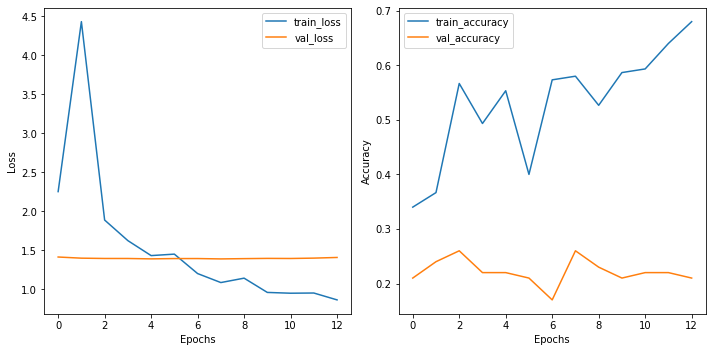

In [115]:
plot_metrics(eleventh_model_results)

# Twelfth Model

Scores were more consistent the last round, still very low. Precision and recall were shot. Let's try reducing the hidden layers. 

In [116]:
twelfth_model = Sequential()

twelfth_model.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(64, 64, 1)))

twelfth_model.add(BatchNormalization())
twelfth_model.add(Dense(128, activation='relu'))
twelfth_model.add(MaxPooling2D(pool_size=(2,2)))
twelfth_model.add(Dropout(0.5))

twelfth_model.add(Flatten())
twelfth_model.add(Dense(64, activation='relu'))
twelfth_model.add(Dense(32, activation='relu'))
twelfth_model.add(Dense(4, activation='softmax'))

In [117]:
twelfth_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
dense_47 (Dense)             (None, 62, 62, 128)       4224      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 31, 31, 128)       0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 123008)            0         
_________________________________________________________________
dense_48 (Dense)             (None, 64)              

In [118]:
twelfth_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', precision, recall])

In [119]:
twelfth_model_results = twelfth_model.fit(X_train, 
                                      y_train, 
                                      batch_size=100, 
                                      epochs=25,
                                      validation_data=(extra_val_images, extra_val_labels),
                                      callbacks=[early_stop])

Epoch 1/25
2/2 [==============================] - 1s 556ms/step - loss: 5.0637 - accuracy: 0.2933 - precision: 0.4615 - recall: 0.1200 - val_loss: 2.0556 - val_accuracy: 0.2700 - val_precision: 0.2727 - val_recall: 0.2700
Epoch 2/25
2/2 [==============================] - 0s 219ms/step - loss: 15.8445 - accuracy: 0.3400 - precision: 0.3400 - recall: 0.3400 - val_loss: 1.5669 - val_accuracy: 0.2200 - val_precision: 0.2105 - val_recall: 0.0800
Epoch 3/25
2/2 [==============================] - 1s 317ms/step - loss: 5.1122 - accuracy: 0.4800 - precision: 0.4800 - recall: 0.4800 - val_loss: 1.4657 - val_accuracy: 0.2300 - val_precision: 0.1429 - val_recall: 0.0200
Epoch 4/25
2/2 [==============================] - 1s 365ms/step - loss: 3.3713 - accuracy: 0.3933 - precision: 0.3960 - recall: 0.3933 - val_loss: 1.3918 - val_accuracy: 0.2500 - val_precision: 0.2000 - val_recall: 0.0100
Epoch 5/25
2/2 [==============================] - 1s 371ms/step - loss: 2.2926 - accuracy: 0.3200 - precision: 

In [120]:
evaluate_model(twelfth_model)

2/2 [==============================] - 0s 22ms/step - loss: 1.3501 - accuracy: 0.3600 - precision: 0.0000e+00 - recall: 0.0000e+00
Training Loss: 1.34 
Training Accuracy: 0.38 
Training Precision: 0.0 
Training Recall: 0.0
---------------------------
Testing Loss: 1.35 
Testing Accuracy: 0.36 
Testing Precision: 0.0 
Testing Recall: 0.0


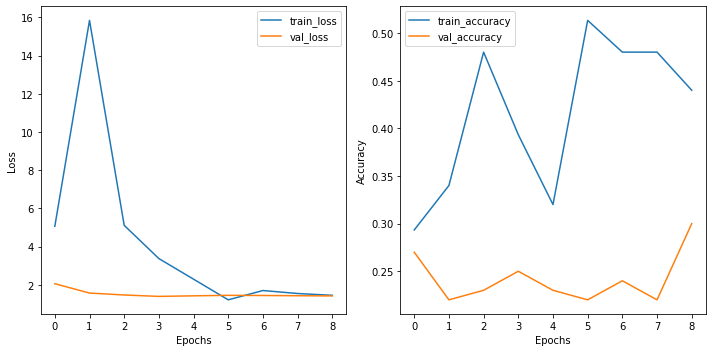

In [121]:
plot_metrics(twelfth_model_results)

Ok, that helped improve the training score. Test score is still low, let's add regularization back in. 

# Thirteenth Model

In [122]:
thirteenth_model = Sequential()

thirteenth_model.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(64, 64, 1),
                        kernel_regularizer=l2(0.00001)))

thirteenth_model.add(BatchNormalization())
thirteenth_model.add(Dense(128, activation='relu'))
thirteenth_model.add(MaxPooling2D(pool_size=(2,2)))
thirteenth_model.add(Dropout(0.5))

thirteenth_model.add(Flatten())
thirteenth_model.add(Dense(64, activation='relu'))
thirteenth_model.add(Dense(32, activation='relu'))
thirteenth_model.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.00001)))

In [123]:
thirteenth_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_5 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
dense_51 (Dense)             (None, 62, 62, 128)       4224      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 31, 31, 128)       0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 123008)            0         
_________________________________________________________________
dense_52 (Dense)             (None, 64)              

In [124]:
thirteenth_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', precision, recall])

In [125]:
thirteenth_model_results = thirteenth_model.fit(X_train, 
                                      y_train, 
                                      batch_size=100, 
                                      epochs=25,
                                      validation_data=(extra_val_images, extra_val_labels),
                                      callbacks=[early_stop])

Epoch 1/25
2/2 [==============================] - 1s 669ms/step - loss: 2.8656 - accuracy: 0.3267 - precision: 0.4444 - recall: 0.1200 - val_loss: 1.8167 - val_accuracy: 0.2700 - val_precision: 0.2727 - val_recall: 0.2700
Epoch 2/25
2/2 [==============================] - 1s 310ms/step - loss: 13.3905 - accuracy: 0.3133 - precision: 0.3133 - recall: 0.3133 - val_loss: 1.4530 - val_accuracy: 0.2200 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
2/2 [==============================] - 1s 336ms/step - loss: 2.0694 - accuracy: 0.4333 - precision: 0.4437 - recall: 0.4200 - val_loss: 1.4782 - val_accuracy: 0.1800 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
2/2 [==============================] - 1s 322ms/step - loss: 2.8178 - accuracy: 0.4067 - precision: 0.4122 - recall: 0.4067 - val_loss: 1.4470 - val_accuracy: 0.2200 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
2/2 [==============================] - 1s 336ms/step - loss: 1.7277 - accura

In [126]:
evaluate_model(thirteenth_model)

2/2 [==============================] - 0s 18ms/step - loss: 1.3727 - accuracy: 0.3600 - precision: 0.0000e+00 - recall: 0.0000e+00
Training Loss: 1.29 
Training Accuracy: 0.733 
Training Precision: 0.0 
Training Recall: 0.0
---------------------------
Testing Loss: 1.37 
Testing Accuracy: 0.36 
Testing Precision: 0.0 
Testing Recall: 0.0


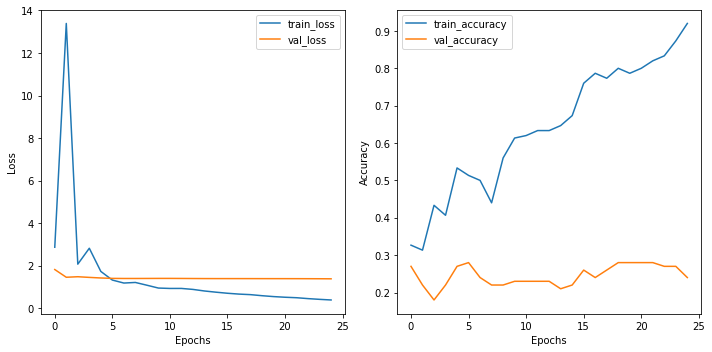

In [127]:
plot_metrics(thirteenth_model_results)

# Fourteenth Model

Let's add learning rate.

In [128]:
fourteenth_model = Sequential()

fourteenth_model.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(64, 64, 1),
                        kernel_regularizer=l2(0.00001)))

fourteenth_model.add(BatchNormalization())
fourteenth_model.add(Dense(128, activation='relu'))
fourteenth_model.add(MaxPooling2D(pool_size=(2,2)))
fourteenth_model.add(Dropout(0.5))

fourteenth_model.add(Flatten())
fourteenth_model.add(Dense(64, activation='relu'))
fourteenth_model.add(Dense(32, activation='relu'))
fourteenth_model.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.00001)))

In [129]:
fourteenth_model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', precision, recall])

In [130]:
fourteenth_model_results = fourteenth_model.fit(X_train, 
                                      y_train, 
                                      batch_size=100, 
                                      epochs=25,
                                      validation_data=(extra_val_images, extra_val_labels),
                                      callbacks=[early_stop])

Epoch 1/25
2/2 [==============================] - 1s 652ms/step - loss: 3.8265 - accuracy: 0.3067 - precision: 0.5185 - recall: 0.1400 - val_loss: 1.5968 - val_accuracy: 0.2800 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
2/2 [==============================] - 1s 287ms/step - loss: 5.0926 - accuracy: 0.3733 - precision: 0.3733 - recall: 0.3733 - val_loss: 1.3976 - val_accuracy: 0.2200 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
2/2 [==============================] - 1s 362ms/step - loss: 2.1505 - accuracy: 0.4400 - precision: 0.4514 - recall: 0.4333 - val_loss: 1.3606 - val_accuracy: 0.3700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
2/2 [==============================] - 1s 403ms/step - loss: 1.3204 - accuracy: 0.4267 - precision: 0.4298 - recall: 0.3467 - val_loss: 1.3926 - val_accuracy: 0.2400 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
2/2 [==============================] - 1s 325ms/step - loss: 0.9183 -

In [131]:
evaluate_model(fourteenth_model)

2/2 [==============================] - 0s 22ms/step - loss: 1.3824 - accuracy: 0.2600 - precision: 0.0000e+00 - recall: 0.0000e+00
Training Loss: 1.26 
Training Accuracy: 0.547 
Training Precision: 0.0 
Training Recall: 0.0
---------------------------
Testing Loss: 1.38 
Testing Accuracy: 0.26 
Testing Precision: 0.0 
Testing Recall: 0.0


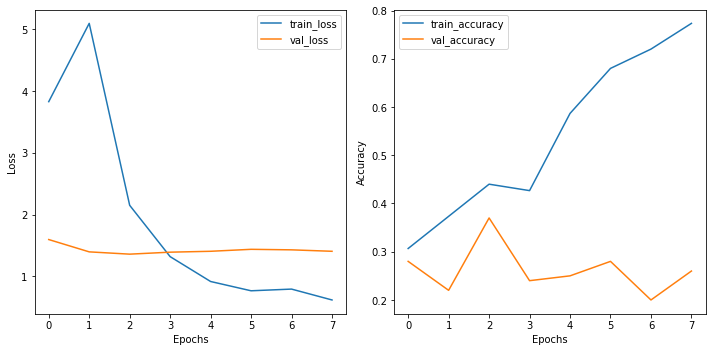

In [132]:
plot_metrics(fourteenth_model_results)

# Fifteenth Model

Let's change to tanh

In [133]:
fifteenth_model = Sequential()

fifteenth_model.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=(64, 64, 1),
                        kernel_regularizer=l2(0.00001)))

fifteenth_model.add(BatchNormalization())
fifteenth_model.add(Dense(128, activation='tanh'))
fifteenth_model.add(MaxPooling2D(pool_size=(2,2)))
fifteenth_model.add(Dropout(0.5))

fifteenth_model.add(Flatten())
fifteenth_model.add(Dense(64, activation='tanh'))
fifteenth_model.add(Dense(32, activation='tanh'))
fifteenth_model.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.00001)))

In [134]:
fifteenth_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_7 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
dense_59 (Dense)             (None, 62, 62, 128)       4224      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 31, 31, 128)       0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 123008)            0         
_________________________________________________________________
dense_60 (Dense)             (None, 64)              

In [135]:
fifteenth_model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', precision, recall])

In [136]:
fifteenth_model_results = fifteenth_model.fit(X_train, 
                                      y_train, 
                                      batch_size=100, 
                                      epochs=25,
                                      validation_data=(extra_val_images, extra_val_labels),
                                      callbacks=[early_stop])

Epoch 1/25
2/2 [==============================] - 1s 614ms/step - loss: 1.7456 - accuracy: 0.2467 - precision: 0.3077 - recall: 0.1200 - val_loss: 2.8370 - val_accuracy: 0.2200 - val_precision: 0.2121 - val_recall: 0.2100
Epoch 2/25
2/2 [==============================] - 1s 273ms/step - loss: 1.5065 - accuracy: 0.5200 - precision: 0.5145 - recall: 0.4733 - val_loss: 2.8628 - val_accuracy: 0.2300 - val_precision: 0.2300 - val_recall: 0.2300
Epoch 3/25
2/2 [==============================] - 1s 355ms/step - loss: 1.3891 - accuracy: 0.5600 - precision: 0.5804 - recall: 0.5533 - val_loss: 2.8430 - val_accuracy: 0.2200 - val_precision: 0.2222 - val_recall: 0.2200
Epoch 4/25
2/2 [==============================] - 1s 314ms/step - loss: 1.3131 - accuracy: 0.5533 - precision: 0.5948 - recall: 0.4600 - val_loss: 2.7786 - val_accuracy: 0.2200 - val_precision: 0.2200 - val_recall: 0.2200
Epoch 5/25
2/2 [==============================] - 1s 306ms/step - loss: 1.2614 - accuracy: 0.5200 - precision: 0

In [137]:
evaluate_model(fifteenth_model)

2/2 [==============================] - 0s 19ms/step - loss: 1.6650 - accuracy: 0.4000 - precision: 0.3913 - recall: 0.3600
Training Loss: 1.29 
Training Accuracy: 0.507 
Training Precision: 0.5 
Training Recall: 0.46
---------------------------
Testing Loss: 1.67 
Testing Accuracy: 0.4 
Testing Precision: 0.391 
Testing Recall: 0.36


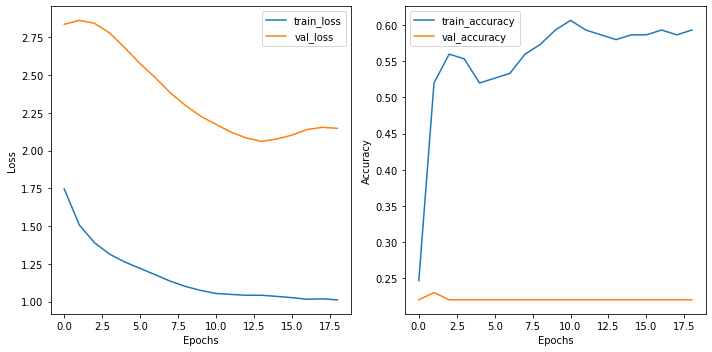

In [138]:
plot_metrics(fifteenth_model_results)

# Sixteenth Model

We have an imbalanced dataset, nothing above seems to be helping, let's try adjusting the class weights. 

In [140]:
y_ints = [y.argmax() for y in y_train]
class_weights = compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_ints),
                                                  y=y_ints)

# turn into dict so it can be put in the fit statement
class_weights_dict = {class_index: weight for class_index, weight in enumerate(class_weights)}

In [147]:
sixteenth_model = Sequential()

sixteenth_model.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(64, 64, 1),
                        kernel_regularizer=l2(0.00001)))

sixteenth_model.add(BatchNormalization())
sixteenth_model.add(Dense(128, activation='relu'))
sixteenth_model.add(MaxPooling2D(pool_size=(2,2)))
sixteenth_model.add(Dropout(0.5))

sixteenth_model.add(Flatten())
sixteenth_model.add(Dense(64, activation='relu'))
sixteenth_model.add(Dense(32, activation='relu'))
sixteenth_model.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.00001)))

In [148]:
sixteenth_model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_9 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
dense_67 (Dense)             (None, 62, 62, 128)       4224      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 31, 31, 128)       0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 123008)            0         
_________________________________________________________________
dense_68 (Dense)             (None, 64)              

In [149]:
sixteenth_model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', precision, recall])

In [150]:
sixteenth_model_results = sixteenth_model.fit(X_train, 
                                      y_train, 
                                      batch_size=100, 
                                      epochs=25,
                                      validation_data=(extra_val_images, extra_val_labels),
                                      callbacks=[early_stop],
                                      class_weight=class_weights_dict)

Epoch 1/25
2/2 [==============================] - 1s 508ms/step - loss: 1.9918 - accuracy: 0.4200 - precision: 0.4105 - recall: 0.1950 - val_loss: 1.3584 - val_accuracy: 0.3300 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
2/2 [==============================] - 0s 166ms/step - loss: 4.6778 - accuracy: 0.2200 - precision: 0.2200 - recall: 0.2200 - val_loss: 1.3878 - val_accuracy: 0.2400 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
2/2 [==============================] - 0s 181ms/step - loss: 2.3582 - accuracy: 0.3400 - precision: 0.3130 - recall: 0.2733 - val_loss: 1.3902 - val_accuracy: 0.2600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
2/2 [==============================] - 0s 175ms/step - loss: 1.7848 - accuracy: 0.3000 - precision: 0.3125 - recall: 0.2667 - val_loss: 1.3950 - val_accuracy: 0.2300 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
2/2 [==============================] - 0s 165ms/step - loss: 1.3284 -

In [151]:
evaluate_model(sixteenth_model)

2/2 [==============================] - 0s 14ms/step - loss: 1.3911 - accuracy: 0.1600 - precision: 0.0000e+00 - recall: 0.0000e+00
Training Loss: 1.34 
Training Accuracy: 0.453 
Training Precision: 0.0 
Training Recall: 0.0
---------------------------
Testing Loss: 1.39 
Testing Accuracy: 0.16 
Testing Precision: 0.0 
Testing Recall: 0.0


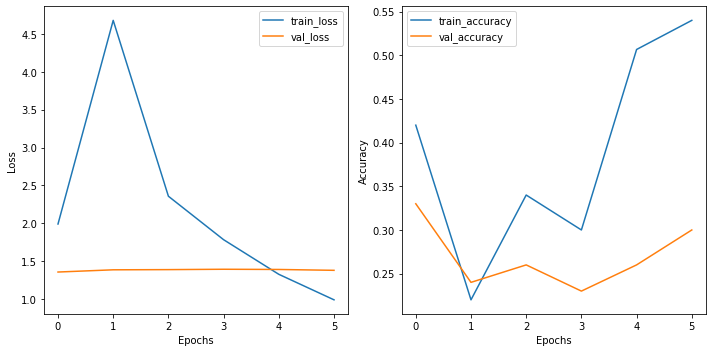

In [152]:
plot_metrics(sixteenth_model_results)

# Seventeenth Model

In [153]:
seventeenth_model = Sequential()

seventeenth_model.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(64, 64, 1),
                        kernel_regularizer=l2(0.00001)))

seventeenth_model.add(BatchNormalization())
seventeenth_model.add(Dense(128, activation='relu'))
seventeenth_model.add(MaxPooling2D(pool_size=(2,2)))
seventeenth_model.add(Dropout(0.5))

seventeenth_model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
seventeenth_model.add(BatchNormalization())
seventeenth_model.add(Dense(128, activation='relu'))
seventeenth_model.add(MaxPooling2D(pool_size=(2,2)))
seventeenth_model.add(Dropout(0.5))

seventeenth_model.add(Flatten())
seventeenth_model.add(Dense(64, activation='relu'))
seventeenth_model.add(Dense(32, activation='relu'))
seventeenth_model.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.00001)))

In [154]:
seventeenth_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_10 (Batc (None, 62, 62, 32)        128       
_________________________________________________________________
dense_71 (Dense)             (None, 62, 62, 128)       4224      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 29, 29, 32)        36896     
_________________________________________________________________
batch_normalization_11 (Batc (None, 29, 29, 32)      

In [155]:
seventeenth_model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', precision, recall])

In [156]:
seventeenth_model_results = seventeenth_model.fit(X_train, 
                                      y_train, 
                                      batch_size=100, 
                                      epochs=25,
                                      validation_data=(extra_val_images, extra_val_labels),
                                      callbacks=[early_stop],
                                      class_weight=class_weights_dict)

Epoch 1/25
2/2 [==============================] - 1s 501ms/step - loss: 2.3461 - accuracy: 0.3067 - precision: 0.3793 - recall: 0.1650 - val_loss: 1.3899 - val_accuracy: 0.1700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
2/2 [==============================] - 0s 222ms/step - loss: 3.6547 - accuracy: 0.1533 - precision: 0.1600 - recall: 0.1333 - val_loss: 1.3820 - val_accuracy: 0.2700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
2/2 [==============================] - 0s 231ms/step - loss: 1.8673 - accuracy: 0.3267 - precision: 0.4000 - recall: 0.2667 - val_loss: 1.3816 - val_accuracy: 0.2900 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
2/2 [==============================] - 0s 224ms/step - loss: 1.4894 - accuracy: 0.4533 - precision: 0.6290 - recall: 0.2600 - val_loss: 1.3840 - val_accuracy: 0.2600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
2/2 [==============================] - 0s 220ms/step - loss: 1.5261 -

In [157]:
evaluate_model(seventeenth_model)

2/2 [==============================] - 0s 24ms/step - loss: 1.3796 - accuracy: 0.3200 - precision: 0.0000e+00 - recall: 0.0000e+00
Training Loss: 1.37 
Training Accuracy: 0.287 
Training Precision: 0.0 
Training Recall: 0.0
---------------------------
Testing Loss: 1.38 
Testing Accuracy: 0.32 
Testing Precision: 0.0 
Testing Recall: 0.0


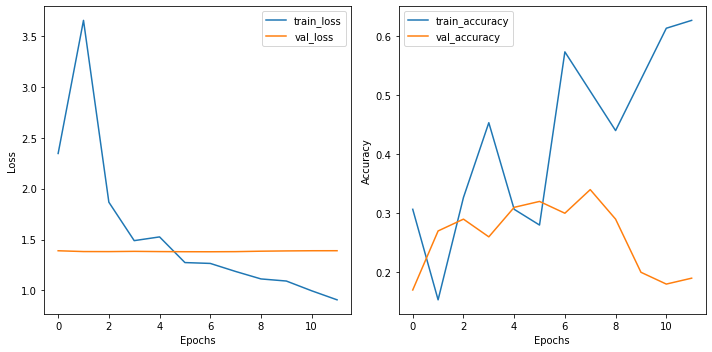

In [158]:
plot_metrics(seventeenth_model_results)

recall v precision: recall prioritizes minimizing false negatives, precision minimizes false positives. We don't want to miss a potential diagnosis and call it normal, so we need to prioritize recall.

Then:
1. train test split (DONE)
2. baseline model (DONE)
3. fsm (DONE)
4. ssm, tsm, etc. until final
5. try gridsearching
6. fine tune activators, optimizers, how many units per layer, num of layers, etc.
7. print scores, plot loss/accuracy/recall, confusion matrix, roc curves. can do functions
8. use sequential models to start, look up other architectures
9. conclusion & next steps

Each session should have: 
1. create model, fit it, look at results, save both model and results
2. loss/accuracy plots, confusion matrices, roc curves
3. explanation of metrics, work out next model, etc.
4. maybe at the end can add a ranking
5. maybe print out some of the predicted labels for an image, inspect it visually